# Lab 6 Report

Prepared by Zech Wolf

## 1. Data preparation

The dataset used is the handwritten letters dataset from EMNIST. There are 26 classes for each of the letters in the Roman alphabet. The full dataset contains over 145,000 instances. The provided training set is used as the full dataset for this report (about 88,000 instances). Each instance is a 28x28 grayscale image containing a handwritten letter.

Dataset source: https://www.kaggle.com/datasets/crawford/emnist?resource=download&select=emnist-letters-train.csv (processed into .csv format from original source)

### 1.1 Performance metrics

A possible business case for this dataset is optical character recognition (OCR), which converts text from an image into digital text on a computer. A classification model trained on this dataset could be used to process handwriting.

The proper metric is accuracy, since all classes are equally important, and the dataset is balanced.

### 1.2 Cross validation method

With nearly 90,000 instances, the dataset is very large. The dataset is also balanced by class. For these reasons, a stratified 80/20 split should be suitable for training and testing. Of the 80% training set, 10% will be set aside as validation data.

In [62]:
import pandas as pd

df = pd.read_csv("datasets/emnist-letters-train.csv")
df["23"] -= 1 #adjust class label to be range 0-25 instead of 1-26

In [63]:
import numpy as np

X = df.drop(columns=df.columns[0]).to_numpy(dtype=np.float32)
X = X.reshape((len(X),28,28,1))  #reshape to tensor format
X /= 255 #normalize images to interval [0,1]

y = df[df.columns[0]].to_numpy()

NUM_CLASSES = 26

In [64]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=1234)

#OHE encode the labels
y_train_ohe = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_ohe = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_ohe = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

## 2. Modeling

Two CNN architectures are tested, with variations on each architecture to produce four different models

### 2.1 Data augmentation and preprocessing

The training set is augmented using random translations and random zooms. 

In [131]:
from keras.models import Sequential
from keras.layers import RandomTranslation, RandomZoom

augment = Sequential([
    RandomTranslation(0.2, 0.2),
    RandomZoom(0.3, 0.3),
])

X_train_aug = augment(X_train, training=True)

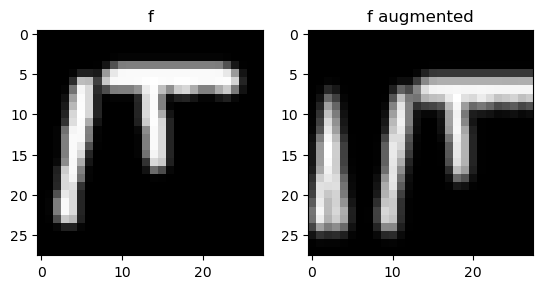

In [132]:
import matplotlib.pyplot as plt

sample = np.random.randint(0, len(X_train_aug))

plt.subplot(1,2,1)
plt.imshow(X_train[sample], cmap="gray")
plt.title(chr(y_train[sample] + 97))

plt.subplot(1,2,2)
plt.imshow(X_train_aug[sample], cmap="gray")
plt.title(chr(y_train[sample] + 97) + " augmented")
plt.show()

#### Convenience functions

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance(hist):
    plt.figure(figsize=(14,6))

    #accuracy plot
    plt.subplot(1,2,1)
    epochs = range(len(hist.epoch))
    accuracy = hist.history["accuracy"]
    val_accuracy = hist.history["val_accuracy"]

    sns.lineplot(x=epochs, y=accuracy, label="Training accuracy")
    sns.lineplot(x=epochs, y=val_accuracy, label="Validation accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epoch")

    #Loss plot
    plt.subplot(1,2,2)
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    sns.lineplot(x=epochs, y=loss, label="Training loss")
    sns.lineplot(x=epochs, y=val_loss, label="Validation loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

In [213]:
from sklearn.metrics import accuracy_score

def model_report(model, y_test):
    y_score = model.predict(X_test)
    y_pred = np.argmax(y_score, axis=1)
    print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
    return y_pred, y_score

In [166]:
#McNemars test for stat comparison
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

### 2.2 CNN Architecture 1

The first architecture is a simple setup with the following components:
* Convolution layer
* Max pooling layer
* Dense output layer

#### 2.2.1 CNN 1
The first implementation of this architecture uses a filter size of 3x3

In [244]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

cnn1 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn1.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [245]:
hist1 = cnn1.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_val, y_val_ohe), verbose=0)

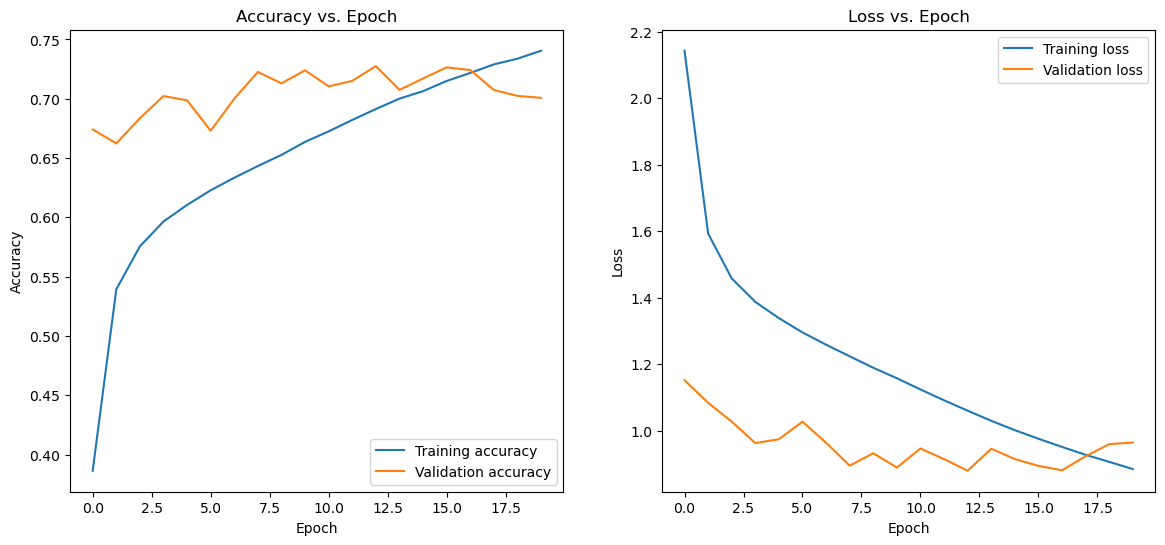

Test set accuracy: 0.706418918918919


In [246]:
plot_performance(hist1)
y_pred_cnn1, y_score_cnn1 = model_report(cnn1, y_test)

The network appears to converge, although the validation loss starts to increase towards the end of training, which could be indicative of overfitting

#### 2.2.2 CNN 2

The second implementation of this architecture uses a larger filter size of 6x6. This should train the model to recognize larger scale features of each letter, and hopefully improve the accuracy

In [247]:
cnn2 = Sequential([
    Conv2D(filters=32, kernel_size=(6,6), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn2.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [248]:
hist2 = cnn2.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_val, y_val_ohe), verbose=0)

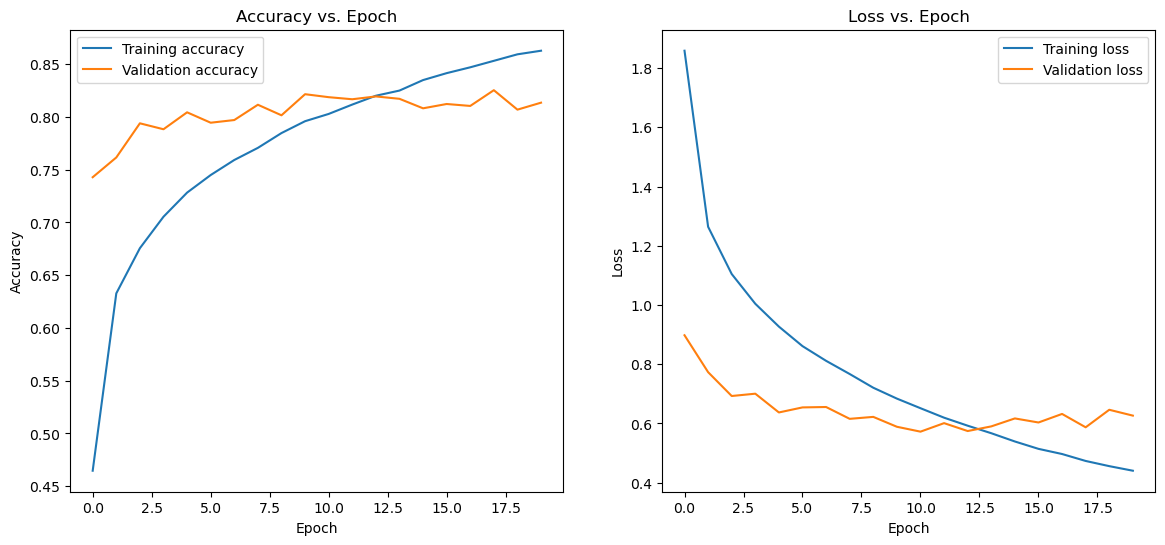

Test set accuracy: 0.8198198198198198


In [249]:
plot_performance(hist2)
y_pred_cnn2, y_score_cnn2 = model_report(cnn2, y_test)

The accuracy is better by about 10% with a larger filter size. It appears that recognizing larger scale features in each image makes a difference. Once again, the validation loss starts to dominate the training loss at the end of training, but the difference is more prominent than in CNN 1

#### 2.2.3 Statistical comparison: CNN 1 vs CNN 2

The two different implemntations of Architecture 1 are compared using McNemar's test (using critical value of $3.841$ for 95% CI)

In [251]:
print(f"CNN1 vs. CNN2: {mcnemar(y_pred_cnn1, y_pred_cnn2, y_test)}")
print(f"CNN 1 accuracy: {accuracy_score(y_test, y_pred_cnn1)}")
print(f"CNN 2 accuracy: {accuracy_score(y_test, y_pred_cnn2)}")

CNN1 vs. CNN2: 1085.790192926045
CNN 1 accuracy: 0.706418918918919
CNN 2 accuracy: 0.8198198198198198


The result of McNemar's test is greater than the critical value, which means there is a statistical difference between the two implementations. Given the higher accuracy of CNN2, we can say that CNN2 is the better model.

### 2.3 CNN Architecture 2

The second architecture uses more convolution layers and adds more dense layers following the convolutions. The components are:
* 3x Convolution and Max Pooling layers (6x6 filters)
* 25% Dropout
* 4x Dense layers
* 50% Dropout

I also use RmsProp instead of AdaM for these implementations

#### 2.3.1 CNN 3
The first implementation of this architecture uses 32, 64, and 128 filters in the three convolution layers

In [269]:
from keras.layers import Dropout

cnn3 = Sequential([
    Conv2D(filters=32, kernel_size=(6,6), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Dropout(0.25),
    Flatten(),

    #Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn3.compile(optimizer="rmsprop", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [270]:
hist3 = cnn3.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_val, y_val_ohe), verbose=0)

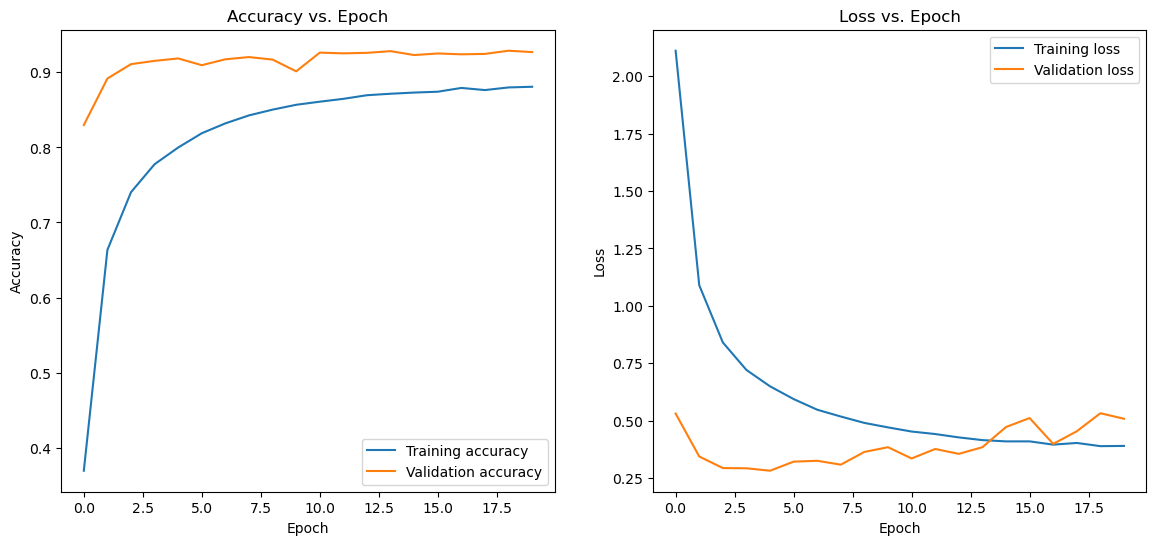

Test set accuracy: 0.932713963963964


In [271]:
plot_performance(hist3)
y_pred_cnn3, y_score_cnn3 = model_report(cnn3, y_test)

The model converges and the accuracy is significantly improved from the best implementation of Architecture 1. Similar to previous models though, the validation accuracy flatlines not very long into training, and the validation loss even starts to increase. The model was only trained for 20 epochs to prevent overfitting because of this.

#### 2.3.2 CNN 4

The next implementation of this architecture uses a higher number of filters: 64, 128, and 256 in the respective convolution layers

In [229]:
cnn4 = Sequential([
    Conv2D(filters=64, kernel_size=(6,6), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(filters=256, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Dropout(0.25),
    Flatten(),

    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn4.compile(optimizer="rmsprop", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [230]:
hist4 = cnn4.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_val, y_val_ohe), verbose=0)

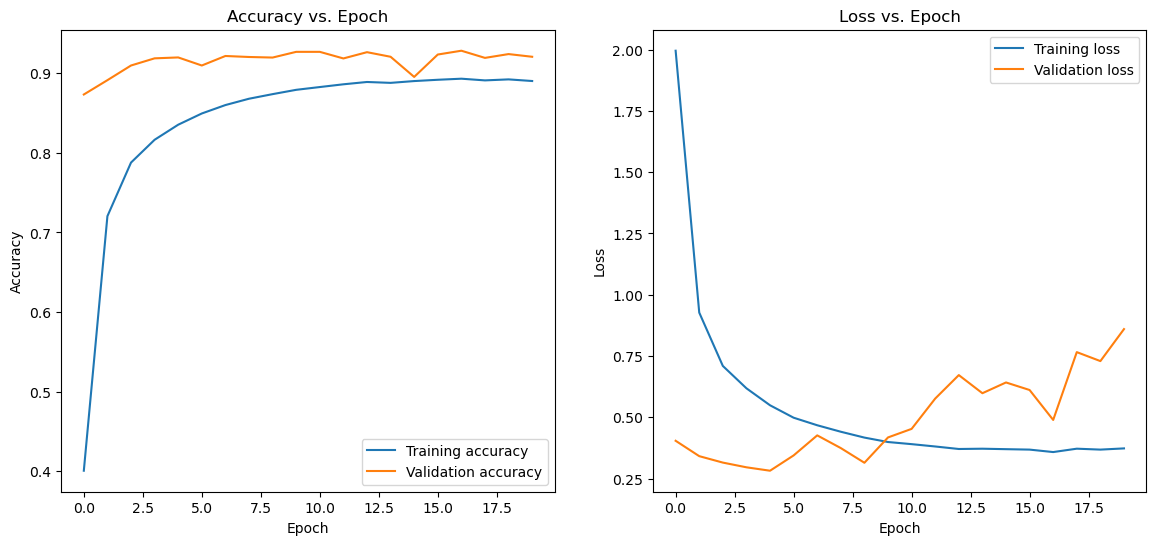

Test set accuracy: 0.9281531531531532


In [232]:
plot_performance(hist4)
y_pred_cnn4, y_score_cnn4 = model_report(cnn4, y_test)

The accuracy is not as good as CNN 3, and the validation loss starts to increase pretty substantially after about 10 epochs. It looks like an increased number of filters is not an advantage, but a statistical comparison is needed to make sure.

#### 2.3.3 Statistical comparison: CNN 3 vs. CNN 4

In [272]:
print(f"CNN3 vs. CNN4: {mcnemar(y_pred_cnn3, y_pred_cnn4, y_test)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")
print(f"CNN 4 accuracy: {accuracy_score(y_test, y_pred_cnn4)}")

CNN3 vs. CNN4: 6.786850477200424
CNN 3 accuracy: 0.932713963963964
CNN 4 accuracy: 0.9281531531531532


The result of McNemar's test is greater than the critical value, so the models are statistically different. Since CNN 3 performed better in terms of accuracy, it is the better model.

#### 2.3.4 Statistical comparison: CNN 2 vs. CNN 3

The best implementation of Architecture 1 (CNN 2) is compared to the best implementation of Architecture 2 (CNN 3) to find the best overall model.

In [252]:
print(f"CNN2 vs. CNN3: {mcnemar(y_pred_cnn2, y_pred_cnn3, y_test)}")
print(f"CNN 2 accuracy: {accuracy_score(y_test, y_pred_cnn2)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")

CNN2 vs. CNN3: 1446.9982917663137
CNN 2 accuracy: 0.8198198198198198
CNN 3 accuracy: 0.9357545045045045


The result is greater than the critical value, so the models are statistically different. CNN 3 had much better accuracy, so it is the best CNN overall.

### 2.4 Comparing to MLP

The best CNN (CNN 3) is compared to to a standard multi-layer perceptron with 4 layers

In [255]:
mlp = Sequential([
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax")
])

mlp.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [256]:
hist_mlp = mlp.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=50, shuffle=True, validation_data=(X_val, y_val_ohe), verbose=0)

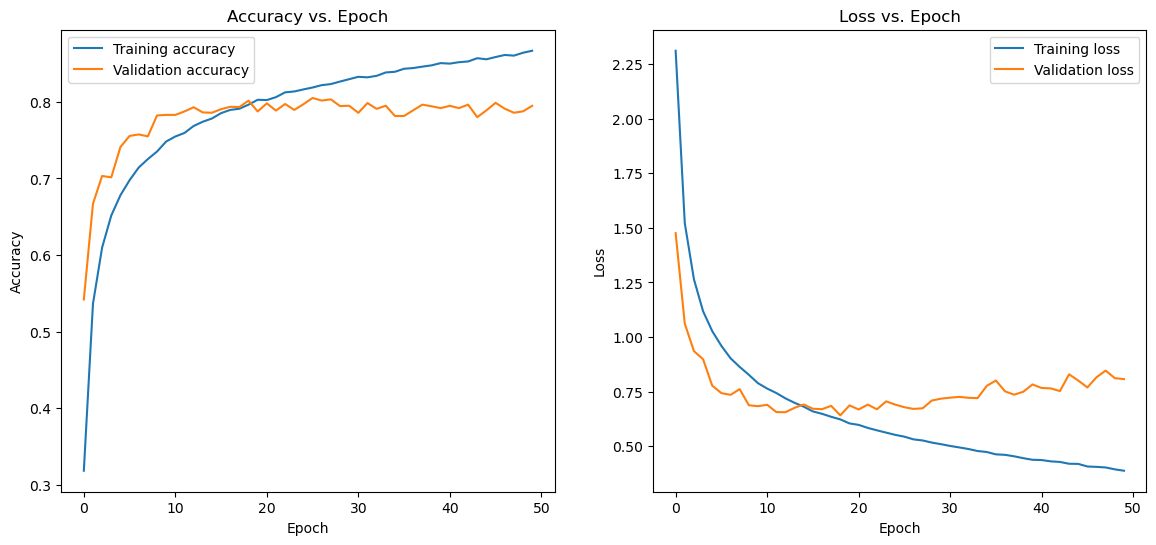

Test set accuracy: 0.8020833333333334


In [258]:
plot_performance(hist_mlp)
y_pred_mlp, y_score_mlp = model_report(mlp, y_test)

#### 2.4.1 ROC curve comparison

For this multiclass problem, the roc_curve is microaveraged

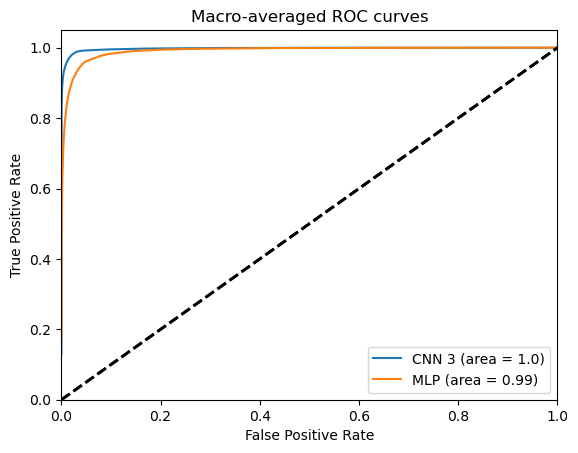

In [307]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

#This code is copied and adapted from sklearn docs here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 

def plot_roc(y_score, y_test_ohe, lbl):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"{lbl} (area = {roc_auc['macro']:{1}.{2}})",
    )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-averaged ROC curves")
    plt.legend(loc="lower right")

    #End code from sklearn docs

plot_roc(y_score_cnn3, y_test_ohe, "CNN 3")
plot_roc(y_score_mlp, y_test_ohe, "MLP")

Based on the ROC curve, CNN 3 appears to be slightly better than the MLP. 

In [308]:
print(f"CNN3 vs. MLP: {mcnemar(y_pred_cnn3, y_pred_mlp, y_test)}")
print(f"CNN 2 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_mlp)}")

CNN3 vs. MLP: 1734.7616129032258
CNN 2 accuracy: 0.932713963963964
CNN 3 accuracy: 0.8020833333333334


McNemar's test shows that there is a statistically significant difference between CNN 3 and the MLP. Given CNN 3's better accuracy and AUC scores, we can determine that it is the better than the multilayer perceptron, and transitively, the best mode overall.